In [9]:
import pandas as pd

# Load movie data
movies = pd.read_csv("movies.csv")
movies.head()


,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
# Combine genres into a single string per movie (already done)
# You can use TF-IDF on genres + title
from sklearn.feature_extraction.text import TfidfVectorizer

movies['content'] = movies['Title'] + " " + movies['Genres'].str.replace('|', ' ')
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['content'])


In [11]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [8]:
# Create reverse mapping of titles
indices = pd.Series(movies.index, index=movies['Title'])

def recommend(title, num=10):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:num+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies['Title'].iloc[movie_indices]


In [5]:
recommend("Toy Story (1995)")


3045                       Toy Story 2 (1999)
3331    We're Back! A Dinosaur's Story (1993)
2892                  Story of Us, The (1999)
2039                        L.A. Story (1991)
12                               Balto (1995)
2205                    Lilian's Story (1995)
292         Pyromaniac's Love Story, A (1995)
236                     Goofy Movie, A (1995)
47                          Pocahontas (1995)
2490                   King and I, The (1999)
Name: Title, dtype: object

In [30]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

# Load Data
movies = pd.read_csv("movies.csv")          # Should contain MovieID and Title
ratings = pd.read_csv("ratings.csv")        # Should contain UserID, MovieID, Rating
users = pd.read_csv("users.csv")            # Optional

# Merge to include only rated movies
rated_movies = movies[movies['MovieID'].isin(ratings['MovieID'].unique())]
rated_movies = rated_movies.reset_index(drop=True)

# --- Content-Based Filtering ---
# Use genres or titles as features. Here, genres are better suited.
movies_genres = rated_movies.copy()
movies_genres['Genres'] = movies_genres['Genres'].fillna('')

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_genres['Genres'])

# Cosine similarity (content-based)
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Mapping from movie title to index
indices = pd.Series(movies_genres.index, index=movies_genres['Title'])

# --- Collaborative Filtering ---
# Build user-item matrix
user_movie_matrix = ratings.pivot(index='UserID', columns='MovieID', values='Rating')

# Transpose to Movie x User and fill missing
movie_user_matrix = user_movie_matrix.T.fillna(0)

# Truncated SVD
svd = TruncatedSVD(n_components=20, random_state=42)
movie_svd = svd.fit_transform(movie_user_matrix)

# Cosine similarity for collaborative filtering
collab_similarity = cosine_similarity(movie_svd)
collab_sim_df = pd.DataFrame(collab_similarity, index=movie_user_matrix.index, columns=movie_user_matrix.index)

# --- Hybrid Recommendation Function ---
def hybrid_recommend(movie_title, top_n=10, alpha=0.5):
    if movie_title not in indices:
        return f"'{movie_title}' not found."

    idx = indices[movie_title]
    movie_id = rated_movies.iloc[idx]['MovieID']

    # Content-based scores
    content_scores = cosine_sim[idx]

    # Collaborative scores
    if movie_id not in collab_sim_df.index:
        return f"No collaborative filtering data for '{movie_title}'."
    collab_scores = collab_sim_df.loc[movie_id].values

    # Combine scores
    hybrid_scores = alpha * content_scores + (1 - alpha) * collab_scores

    # Top N recommended indices
    movie_indices = hybrid_scores.argsort()[::-1][1:top_n+1]
    return rated_movies.iloc[movie_indices]['Title'].reset_index(drop=True)

# --- Example Usage ---
hybrid_recommend("Toy Story (1995)")


0                        Toy Story 2 (1999)
1                      Bug's Life, A (1998)
2                               Antz (1998)
3                        Chicken Run (2000)
4                    Iron Giant, The (1999)
5                            Aladdin (1992)
6                             Tarzan (1999)
7    Aladdin and the King of Thieves (1996)
8                              Mulan (1998)
9                 Rugrats Movie, The (1998)
Name: Title, dtype: object

In [31]:
print(hybrid_recommend("Pulp Fiction (1994)"))
print(hybrid_recommend("Shrek (2001)"))
print(hybrid_recommend("The Matrix (1999)"))


0         GoodFellas (1990)
1       Jackie Brown (1997)
2      Donnie Brasco (1997)
3    Few Good Men, A (1992)
4              Fargo (1996)
5      Carlito's Way (1993)
6           Rounders (1998)
7      Suicide Kings (1997)
8           Sleepers (1996)
9       Grand Canyon (1991)
Name: Title, dtype: object
'Shrek (2001)' not found.
'The Matrix (1999)' not found.


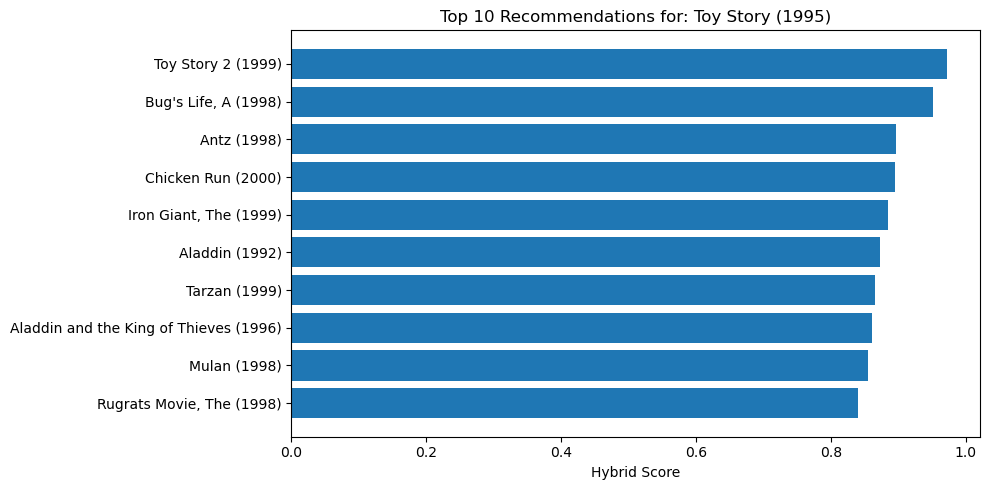

In [32]:
import matplotlib.pyplot as plt

def plot_similarity_scores(movie_title, alpha=0.5, top_n=10):
    idx = indices[movie_title]
    movie_id = rated_movies.iloc[idx]['MovieID']
    
    content_scores = cosine_sim[idx]
    collab_scores = collab_sim_df.loc[movie_id].values
    
    hybrid_scores = alpha * content_scores + (1 - alpha) * collab_scores
    top_indices = hybrid_scores.argsort()[::-1][1:top_n+1]
    
    recommended_titles = rated_movies.iloc[top_indices]['Title'].values
    scores = hybrid_scores[top_indices]
    
    plt.figure(figsize=(10, 5))
    plt.barh(recommended_titles[::-1], scores[::-1])
    plt.xlabel("Hybrid Score")
    plt.title(f"Top {top_n} Recommendations for: {movie_title}")
    plt.tight_layout()
    plt.show()

plot_similarity_scores("Toy Story (1995)")
